In [ ]:
!pip install transformers catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.7 MB/s eta 0:00:00


# Опеределение вида продукции по его описанию.

**Цель:** cоздать модель, обрабатывающую фрагмент текста и определяющую
какой вид продукции в нём содержится.

**Условия:**


*   Фреймворк PyTorch
*   Использовать для обучения записи имеющие не менее 500 позици целевого признака
* Разделение тестовой и тренировочной выборок 20% \ 80%



## Загрузка и анализ датасета:

In [ ]:
import os
import io
import urllib3
import requests
import transformers
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from numpy.random import RandomState

random_state = RandomState(12345)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/meatinfo.csv', sep = ';')
data.columns=['text', 'category']

In [ ]:
data.isna().sum()

text        0
category    1
dtype: int64

#### Пропусков нет! Произведем отбор категорий по заданию заказчика, где для обучения будут использованы категории, записей которых в датасете не менее 500.

In [ ]:
data.sample(10)

,text,category
2679,"Баранина, корейка, 4-5 ребра цена 350 руб.",Баранина
292,"Говядина, бедро, внешняя часть цена 550 руб.",Говядина
10480,"Качественное мясо в Москве Отличное, качест...",Говядина
8444,"Говядина, язык, зачищ. цена 600 руб.",Говядина
13328,Мясо гуся - тушка ГУСИНОЕ МЯСО тушкой продаем ...,Гусь
5632,"Быки +95 245 руб охл Беларуссия Говядина, полу...",Говядина
689,вырезка свиная,Свинина
5405,Говядина подбедерок гост,Говядина
14577,Окорок свиной б/к б/ш Полный ассортимент мяс...,Свинина
8255,"Говядина, шкура, коровы цена 70 руб.",Говядина


In [ ]:
list_category = list((data['category'].value_counts()[data['category'].value_counts()>=500]).index)
list_category

['Говядина', 'Свинина', 'Кура', 'Индейка', 'Баранина', 'Цыпленок']

In [ ]:
data_total = data[data['category'].isin(list_category)]

In [ ]:
data_total.sample(5)

,text,category
1919,Грудка цыпленка бройлера подложка Реализуем Гр...,Цыпленок
14659,"Окорок свиной Окорок зач,охл, 1шт=10кг",Свинина
4045,"Говядина, мясо, односортное цена 229 руб.",Говядина
16218,Суповой набор говяжий от 32 руб.кг Суповой наб...,Говядина
1604,"Баранина, грудинка, нк цена 175 руб.",Баранина


In [ ]:
print(f'Самое длинное описание составляет {len(data_total["text"].max())} символов')

Самое длинное описание составляет 35 символов


<BarContainer object of 6 artists>

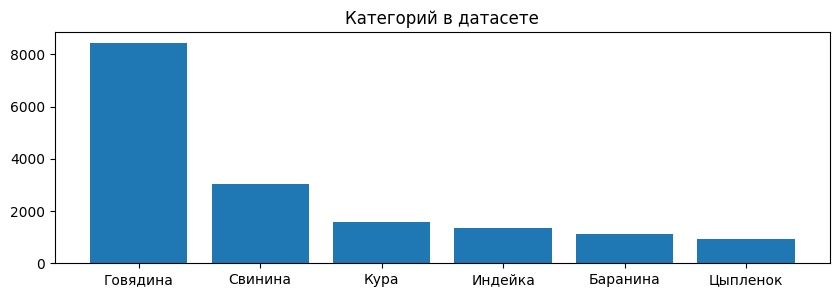

In [ ]:
plt.figure(figsize=(10,3))
plt.title('Категорий в датасете')
plt.bar(x=list_category, height= data_total['category'].value_counts())

#### При разделении на выбороки необходимо проконтроллировать, чтобы все категории попали в обучающую.

## Эмбендинг PyTorch моделью BERT


In [ ]:
tokenaizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
if torch.cuda.is_available():
  model = transformers.AutoModel.from_pretrained('bert-base-uncased').cuda()
else:
  model = transformers.AutoModel.from_pretrained('bert-base-uncased')

In [ ]:
def get_token (data : pd.Series, max_: int):
  features = data['text'].apply(lambda x: tokenaizer.encode(x, add_special_tokens=True)[:512])
  features = np.array([x + [0]*(max_-len(x)) for x in features])
  features_mask = np.where(features!=0, 1,0 )
  return features, features_mask

In [ ]:
def get_embending_feature(batch_size, features, features_mask):
  embendings = []
  for itter in range(features.shape[0]//batch_size):
      if torch.cuda.is_available():
        batch = torch.LongTensor(features[batch_size*itter:batch_size*(itter+1)]).cuda()
        mask_batch = torch.LongTensor(features_mask[batch_size*itter:batch_size*(itter+1)]).cuda()
      else:
        batch = torch.LongTensor(features[batch_size*itter:batch_size*(itter+1)])
        mask_batch = torch.LongTensor(features_mask[batch_size*itter:batch_size*(itter+1)])
      with torch.no_grad():
          batch_embending = model(batch, attention_mask = mask_batch)
      embendings.append(batch_embending[0][:,0,:].cpu().numpy())
  return np.concatenate(embendings)

In [ ]:
features, features_mask = get_token(data_total, 512)


Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
features_bert = get_embending_feature(300, features, features_mask)


In [ ]:
features_bert

array([[-0.6389789 , -0.00998683, -0.17822689, ..., -0.3681441 ,
         0.32523924,  0.5541315 ],
       [-0.6072172 ,  0.02577526, -0.18427771, ..., -0.2681933 ,
         0.58904266,  0.66594964],
       [-0.59320706,  0.00125905, -0.14843278, ..., -0.240804  ,
         0.63262093,  0.667204  ],
       ...,
       [-0.69392323, -0.04900894, -0.07684537, ..., -0.23755117,
         0.7405421 ,  0.47663382],
       [-0.40156093,  0.01794798, -0.01236386, ..., -0.14208667,
         0.6397354 ,  0.46648577],
       [-0.59312356,  0.14421906, -0.2914429 , ..., -0.21458127,
         0.7849555 ,  0.25710952]], dtype=float32)

In [ ]:
data_total['category'].shape

(16438,)

In [ ]:
features_bert.shape

(16200, 768)

In [ ]:
target_bert =  data_total['category'][:features_bert.shape[0]]
target_bert.shape

(16200,)

In [ ]:
target_train, target_test, features_train, features_test = train_test_split(target_bert, features_bert, test_size = 0.2, random_state = random_state)

### CatBosostClassifier model

In [ ]:
if torch.cuda.is_available():
  model_cat = CatBoostClassifier(eval_metric='AUC', verbose=100, task_type="GPU",
                            devices='0:1')
else:
  model_cat = CatBoostClassifier(eval_metric='AUC', verbose=100)

In [ ]:
model_cat.fit(features_train, target_train ,eval_set=(features_test, target_test), use_best_model=True)

Learning rate set to 0.136209


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7390831	best: 0.7390831 (0)	total: 66.6ms	remaining: 1m 6s
100:	test: 0.9312051	best: 0.9312051 (100)	total: 5.83s	remaining: 51.9s
200:	test: 0.9457943	best: 0.9457943 (200)	total: 8.52s	remaining: 33.9s
300:	test: 0.9527004	best: 0.9527004 (300)	total: 11.2s	remaining: 26.1s
400:	test: 0.9554991	best: 0.9554991 (400)	total: 13.9s	remaining: 20.7s
500:	test: 0.9580263	best: 0.9580263 (500)	total: 17.7s	remaining: 17.6s
600:	test: 0.9591037	best: 0.9591743 (590)	total: 22.1s	remaining: 14.7s
700:	test: 0.9601638	best: 0.9602168 (695)	total: 24.7s	remaining: 10.5s
800:	test: 0.9617259	best: 0.9617259 (800)	total: 27.4s	remaining: 6.79s
900:	test: 0.9627142	best: 0.9627142 (900)	total: 29.9s	remaining: 3.29s
999:	test: 0.9627877	best: 0.9629448 (980)	total: 35.8s	remaining: 0us
bestTest = 0.9629447673
bestIteration = 980
Shrink model to first 981 iterations.


In [ ]:
predict = model_cat.predict_proba(features_test)

In [ ]:
roc_auc_score(target_test, predict, multi_class='ovr')

0.9581670668010666

#### CatBoostClassifier дает отличный показатель метрики, после предообработки данных Bert моделью.


## Тестирование модели

In [ ]:
pd_test = pd.DataFrame(data =
        {'text':[
                'Говядина блочная 2 сорт в наличии ООО “АгроСоюз” реализует блочную говядину 2 сорт (80/20)Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.',
                'Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:',
                'Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.'
                ],
         'mtype' : [
            'Говядина',
            'Кура',
            'Говядина']})

In [ ]:
f_t, f_t_mask = get_token(pd_test, max_=512)


In [ ]:
f_t = get_embending_feature(3, f_t, f_t_mask)

In [ ]:
model_cat.predict(f_t)

array([['Говядина'],
       ['Кура'],
       ['Говядина']], dtype=object)

<b> Тест модели пройден успешно.

## Вывод:

Для решения задачи была использована связка двух моделей:
* BERT
* CatBoostClassifier

Достигнута метрика ROC AUC более 0.9, что считается отличным результатом для модели.
На образцах модель также верно определила классификацию текста.

## Production

In [ ]:
class ClassDefinition:
    def __init__(self, url:str = None, path:str = None, column_text:str, column_target:str, sep:str) -> None:
        if url:
          resources_data = requests.get(url)
          self.data = pd.read_csv(io.BytesIO(resources_data.content), sep=sep)
        else:
          self.data = pd.read_csv(path, sep=sep)
        list_category = list((self.data[column_target].value_counts()[self.data[column_target].value_counts()>=500]).index)
        self.data = self.data[self.data[column_target].isin(list_category)]
        self.column_text = column_text
        self.column_target = column_target
        self.model_bert = transformers.AutoModel.from_pretrained('bert-base-uncased').cuda()
        self.tokenaizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
        self.catboost_classifier = CatBoostClassifier(eval_metric='AUC', verbose=100, task_type="GPU",
                            devices='0:1')

    def get_token (self, max_: int) -> None:
        self.features = self.data[self.column_text].apply(lambda x: self.tokenaizer.encode(x, add_special_tokens=True)[:512])
        self.features = np.array([x + [0]*(max_-len(x)) for x in self.features])
        self.features_mask = np.where(self.features!=0, 1,0 )


    def get_embending_feature(self, batch_size: int) -> None:
        embendings = []
        for itter in range(self.features.shape[0]//batch_size):
            batch = torch.LongTensor(self.features[batch_size*itter:batch_size*(itter+1)]).cuda()
            mask_batch = torch.LongTensor(self.features_mask[batch_size*itter:batch_size*(itter+1)]).cuda()
            with torch.no_grad():
                batch_embending = self.model_bert(batch, attention_mask = mask_batch)
            embendings.append(batch_embending[0][:,0,:].cpu().numpy())
        self.features = np.concatenate(embendings)

    def separate_sample(self, test_size: int) -> None:
        self.target_train, \
        self.target_test, \
        self.features_train, \
        self.features_test = train_test_split(self.data[self.column_target][:self.features.shape[0]], self.features, test_size = test_size)

    def train (self, max_: int, batch_size: int, test_size:int) -> None:
        self.max_ = max_
        self.get_token(self.max_)
        self.get_embending_feature(batch_size)
        self.separate_sample(test_size)
        self.catboost_classifier.fit(self.features_train, self.target_train ,eval_set=(self.features_test, self.target_test), use_best_model=True)

    def predict (self, url: str = None, path:str = None, sep:str = None):
        if url:
          resources_data = requests.get(url)
          self.data = pd.read_csv(io.BytesIO(resources_data.content), sep=sep)
        else:
          self.data = pd.read_csv(path, sep=sep)
        self.get_token(self.max_)
        self.get_embending_feature(len(self.data[self.column_target]))
        return self.catboost_classifier.predict(self.data[self.column_text])


In [ ]:
production = ClassDefinition('https://axe.inline-ltd.ru/data/meatinfo.csv','text', 'mtype', ';')

In [ ]:
production.data

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина
...,...,...
17816,"Цыпленок, четвертина, задняя",Цыпленок
17817,"Цыпленок, четвертина, задняя цена 100 руб.",Цыпленок
17818,ЦБ Шеи п/ф Свеженка ГОСТ зам пак Шеи куриные П...,Цыпленок
17819,"Цыпленок, шея, без кожи",Цыпленок


In [ ]:
production.train(512,300,0.2)

Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors


Learning rate set to 0.136209


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7472990	best: 0.7472990 (0)	total: 78.3ms	remaining: 1m 18s
100:	test: 0.9381719	best: 0.9381719 (100)	total: 2.96s	remaining: 26.4s
200:	test: 0.9527465	best: 0.9527465 (200)	total: 5.65s	remaining: 22.5s
300:	test: 0.9584954	best: 0.9584954 (300)	total: 8.31s	remaining: 19.3s
400:	test: 0.9613028	best: 0.9613028 (400)	total: 13.1s	remaining: 19.5s
500:	test: 0.9622987	best: 0.9622987 (500)	total: 15.7s	remaining: 15.6s
600:	test: 0.9632234	best: 0.9632234 (600)	total: 18.3s	remaining: 12.1s
700:	test: 0.9646499	best: 0.9647729 (690)	total: 20.9s	remaining: 8.92s
800:	test: 0.9650156	best: 0.9650648 (790)	total: 24.2s	remaining: 6.02s
900:	test: 0.9654936	best: 0.9655718 (880)	total: 28.2s	remaining: 3.1s
999:	test: 0.9658766	best: 0.9659060 (980)	total: 30.8s	remaining: 0us
bestTest = 0.965906013
bestIteration = 980
Shrink model to first 981 iterations.
